In [ ]:
!pip3 install torch torchvision colpali-engine==0.3.1 vidore_benchmark==4.0.0 pdf2image google-generativeai pypdf==5.0.1 pyvespa vespacli requests

In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from io import BytesIO

from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from vidore_benchmark.utils.image_utils import scale_image, get_base64_image

In [2]:
device = get_torch_device("auto")
if device == "cuda":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

In [3]:
model = ColPali.from_pretrained("vidore/colpali-v1.2", torch_dtype=dtype, device_map=device).eval()
processor = ColPaliProcessor.from_pretrained("vidore/colpali-v1.2")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from pdf2image import convert_from_path
from pypdf import PdfReader

def get_pdf_images(pdf_path):
    reader = PdfReader(pdf_path)
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path(pdf_path)
    assert len(images) == len(page_texts)
    return (images, page_texts)

In [5]:
sample_pdfs = [
    {
        "title": "Damski biznes - spektakl komediowy",
        "path": "/Users/gro/Desktop/pystok/pdf/bilet1.pdf"
    },
    {
        "title": "Optymiści, czyli nasi w Egipcie",
        "path": "/Users/gro/Desktop/pystok/pdf/bilet2.pdf"
    },
]

In [6]:
for pdf in sample_pdfs:
    page_images, page_texts = get_pdf_images(pdf["path"])
    pdf["images"] = page_images
    pdf["texts"] = page_texts

In [7]:
for pdf in sample_pdfs:
    page_embeddings = []
    dataloader = DataLoader(
        pdf["images"],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x),
    )
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
            embeddings_doc = model(**batch_doc)
            if model.device == "cuda":
                embeddings_doc = embeddings_doc.float()
            page_embeddings.extend(list(torch.unbind(embeddings_doc.cpu())))
    pdf["embeddings"] = page_embeddings

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.63s/it]
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as th

In [8]:
import numpy as np
from typing import Dict, List
from binascii import hexlify

def binarize_token_vectors_hex(vectors: List[torch.Tensor]) -> Dict[str, str]:
    vespa_tensor = list()
    for page_id in range(0, len(vectors)):
        page_vector = vectors[page_id]
        binarized_token_vectors = np.packbits(
            np.where(page_vector > 0, 1, 0), axis=1
        ).astype(np.int8)
        for patch_index in range(0, len(page_vector)):
            values = str(
                hexlify(binarized_token_vectors[patch_index].tobytes()), "utf-8"
            )
            if (
                values == "00000000000000000000000000000000"
            ):
                continue
            vespa_tensor_cell = {
                "address": {"page": page_id, "patch": patch_index},
                "values": values,
            }
            vespa_tensor.append(vespa_tensor_cell)
    return vespa_tensor

In [9]:
vespa_feed = []
for index, pdf in enumerate(sample_pdfs):
    images_base_64 = []
    for image in pdf["images"]:
        images_base_64.append(get_base64_image(image, add_url_prefix=False))
    pdf["images_base_64"] = images_base_64
    doc = {
        "fields": {
            "path": pdf["path"],
            "title": pdf["title"],
            "images": pdf["images_base_64"],
            "texts": pdf["texts"],  
            "colbert": {
                "blocks": binarize_token_vectors_hex(pdf["embeddings"])
            },
        }
    }
    vespa_feed.append(doc)

In [10]:
vespa_feed[0]["fields"]["colbert"]["blocks"][0:5]

[{'address': {'page': 0, 'patch': 0},
  'values': 'facbca6953f400ead750911b2ab973d9'},
 {'address': {'page': 0, 'patch': 1},
  'values': '243a9c116b2fac813cde9a759a76435e'},
 {'address': {'page': 0, 'patch': 2},
  'values': '2ca2028987c18dde28c8ab2d8287ce5f'},
 {'address': {'page': 0, 'patch': 3},
  'values': 'f207a6d0732a6d0960f1ad3426e1304c'},
 {'address': {'page': 0, 'patch': 4},
  'values': 'b8992ba1acaea9a9350eb16fac5cb95f'}]

In [11]:
from vespa.package import Schema, Document, Field, FieldSet

pystok_schema = Schema(
    name="doc",
    document=Document(
        fields=[
            Field(name="path", type="string", indexing=["summary"]),
            Field(
                name="title",
                type="string",
                indexing=["summary", "index"],
                index="enable-bm25",
            ),
            Field(
                name="texts",
                type="array<string>",
                indexing=["index"],
                index="enable-bm25",
            ),
            Field(
                name="images",
                type="array<string>",
                indexing=["summary"],
            ),
            Field(
                name="colbert",
                type="tensor<int8>(page{}, patch{}, v[16])",
                indexing=["attribute"],
            ),
        ]
    ),
    fieldsets=[FieldSet(name="default", fields=["title", "texts"])],
)

In [12]:
from vespa.package import ApplicationPackage

vespa_app_name = "pystok"
vespa_application_package = ApplicationPackage(
    name=vespa_app_name, schema=[pystok_schema]
)

In [13]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

pystok_profile = RankProfile(
    name="default",
    inputs=[("query(qt)", "tensor<float>(querytoken{}, v[128])")],
    functions=[
        Function(
            name="max_sim_per_page",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(colbert)) , v
                        ),
                        max, patch
                    ),
                    querytoken
                )
            """,
        ),
        Function(name="max_sim", expression="reduce(max_sim_per_page, max, page)"),
        Function(name="bm25_score", expression="bm25(title) + bm25(texts)"),
    ],
    first_phase=FirstPhaseRanking(expression="bm25_score"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=10),
    match_features=["max_sim_per_page", "bm25_score"],
)
pystok_schema.add_rank_profile(pystok_profile)

In [14]:
from vespa.deployment import VespaDocker

vespa_docker = VespaDocker()
app = vespa_docker.deploy(application_package=vespa_application_package)

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Waiting for application to come up, 15/300 seconds.
Waiting for application to come up, 20/300 seconds.
Waiting for application to come up, 25/300 seconds.
Waiting for application to come up, 30/300 seconds.
Application is up!
Finished deployment.


In [15]:
from vespa.io import VespaResponse

with app.syncio() as sync:
    for operation in vespa_feed:
        fields = operation["fields"]
        response: VespaResponse = sync.feed_data_point(
            data_id=fields["path"], fields=fields, schema="doc"
        )
        if not response.is_successful():
            print(response.json())

In [16]:
queries = ["spektakl teatralny"]

In [17]:
dataloader = DataLoader(
    queries,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: processor.process_queries(x),
)
qs = []
for batch_query in dataloader:
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
        if model.device == "cuda":
            embeddings_query = embeddings_query.float()
        qs.extend(list(torch.unbind(embeddings_query.cpu())))

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


In [18]:
def float_query_token_vectors(vectors: torch.Tensor) -> Dict[str, List[float]]:
    vespa_token_dict = dict()
    for index in range(0, len(vectors)):
        vespa_token_dict[index] = vectors[index].tolist()
    return vespa_token_dict

In [19]:
from IPython.display import display, HTML
import base64

def display_results(query, response):
    html_content = f"<h3>Zadane zapytanie: {query}</h3>"

    for index, hit in enumerate(response.hits[:2]):
        title = hit["fields"]["title"]
        url = hit["fields"]["path"]
        match_scores = hit["fields"]["matchfeatures"]["max_sim_per_page"]
        images = hit["fields"]["images"]

        html_content += f"<h3>Wynik {index + 1}</h3>"
        html_content += f'<p><strong>Tytuł:</strong> {title}</p>'

        sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
        best_pages = sorted_pages[:2]

        for page, score in best_pages:
            page = int(page)
            image_data = base64.b64decode(images[page])
            image = Image.open(BytesIO(image_data))
            scaled_image = scale_image(image, 648)

            buffered = BytesIO()
            scaled_image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            html_content += f"<p><strong>Strona {page+1} dokumentu:</strong> z MaxSim score {score:.2f}</p>"
            html_content += (
                f'<img src="data:image/png;base64,{img_str}" style="max-width:100%;">'
            )

    display(HTML(html_content))


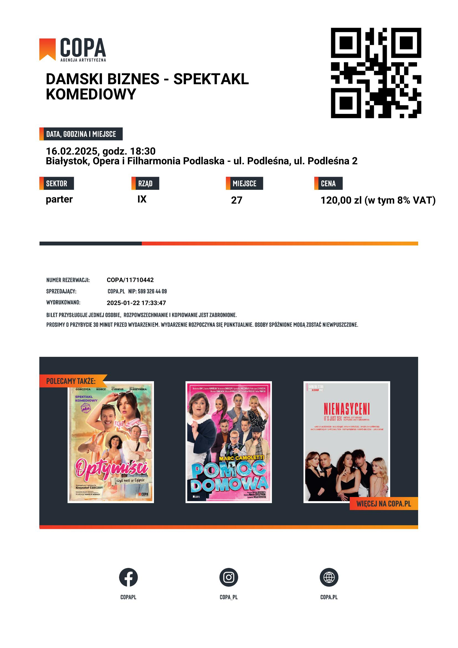
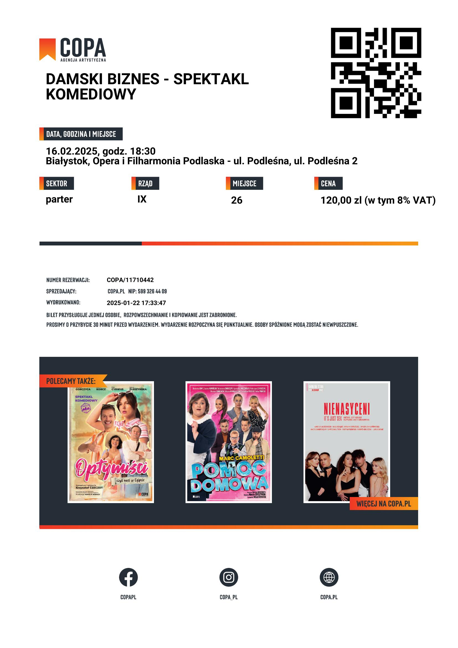

In [20]:
from vespa.io import VespaQueryResponse

for index, query in enumerate(queries):
    response: VespaQueryResponse = app.query(
        yql="select title, path, images from doc where userInput(@userQuery)",
        ranking="default",
        userQuery=query,
        timeout=2,
        hits=3,
        body={
            "presentation.format.tensors": "short-value",
            "input.query(qt)": float_query_token_vectors(qs[index]),
        },
    )
    assert response.is_successful()
    display_results(query, response)

In [21]:
vespa_docker.container.stop()
vespa_docker.container.remove()